In [19]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Import utility functions
from utils import (
    load_data, 
    compute_log_returns, 
    compute_realized_volatility, 
    directional_accuracy,
    build_sequences
)

# Add the path to the custom library to the system path
sys.path.append(str(Path().resolve().parent))

# Import the module from the custom library
from src import Tensor, metrics
from src.core.utils import data_processing, context_manager
from src.architectures.auto_regressive import AutoRegressive

### Constants


In [20]:
# Define the model to load
model_to_load = "lstm" # Available options: "rnn", "lstm", "gru", "transformer"

# Define constants
model_path = os.path.join(os.getcwd(), 'checkpoints', f'stock_prediction_{model_to_load}')
dataset_path = os.path.join(os.getcwd(), 'dataset', 'SPX.csv')

# Define feature configuration
feature_columns = ['Open', 'High', 'Low', 'Close']
close_price_idx = feature_columns.index('Close')

# Define inference configuration
volatility_window = 5
num_generation_steps = 8
batch_size = 64

### Load the model


In [21]:
# Load the trained model
model: AutoRegressive = AutoRegressive.load(model_path)

# Set the model to evaluation mode
model.eval()

# Print model settings used during inference
print('Max sequence length:', model.max_sequence_length)
print('Input type:', model.input_type)

Max sequence length: 48
Input type: continuous


### Load and preprocess data


In [22]:
# Load raw data
data = load_data(dataset_path)
features = np.array([[np.float32(row[k]) for k in feature_columns] for row in data], dtype=np.float32)

# Compute log returns from the selected feature
log_returns = compute_log_returns(features)

# Compute target/input domain
input_data = log_returns[volatility_window:]
target_data = compute_realized_volatility(log_returns, volatility_window)

# Build synthetic timestamps aligned with the selected input domain
seq_timestamps = np.arange(len(input_data), dtype=np.int32)

# Build sequences using model max sequence length
X_sequences_data, y_sequences_data, _ = build_sequences(
    input_data,
    target_data,
    seq_timestamps,
    model.max_sequence_length
)

# Convert sequences to tensors
X_sequences, y_sequences = Tensor(X_sequences_data), Tensor(y_sequences_data)

# Compute normalization stats from available sequences
mean, std, min_val, max_val = data_processing.compute_stats(X_sequences, axis=(0, 1))

In [23]:
# Define normalization function based on the selected method
def normalization_fn(x: Tensor) -> Tensor:
    """
    Normalize input data according to selected normalization method.

    Args:
        x (Tensor): Input tensor to be normalized.

    Returns:
        Tensor: Normalized tensor.
    """

    # Configure normalization function based on the selected method
    return data_processing.z_score_normalize(x, mean, std)

In [24]:
# Normalize inputs for one-step inference
X_sequences_norm = normalization_fn(X_sequences)

### Inference


In [ ]:
# Evaluate one-step predictions on the latest samples
eval_samples = min(512, X_sequences_norm.shape[0])
X_eval = X_sequences_norm[-eval_samples:]
y_eval = y_sequences[-eval_samples:]

# Perform one-step inference without gradient tracking.
with context_manager.no_grad():
    # Get model predictions for the evaluation set.
    preds_out = model(x=X_eval, batch_size=batch_size, verbose=True)

# Extract predictions from the model output.
predictions = preds_out.output

# Compute mean absolute error and directional accuracy for the one-step predictions.
mae = metrics.mean_absolute_error(predictions, y_eval)
dir_acc = directional_accuracy(predictions.to_numpy(), y_eval.to_numpy(), close_price_idx)

# Print evaluation results for one-step predictions.
print(f'\nOne-step MAE: {mae.to_numpy()}')
print(f'One-step directional accuracy: {dir_acc:.3f}')

# Multi-step forecasting from a recent context window
available_steps = min(num_generation_steps, X_sequences.shape[0])
start_idx = max(0, X_sequences.shape[0] - available_steps)
initial_seq = X_sequences[start_idx:start_idx + 1]
true_continuation = y_sequences[start_idx:start_idx + available_steps]

# Keep walk-forward inputs in the log-return domain.
generated_steps = []
current_seq = initial_seq

# Disable gradient tracking for generation loop.
with context_manager.no_grad():
    # Generate future steps iteratively, 
    # using the true next input for each step to maintain the walk-forward approach.
    for step in range(available_steps):
        step_out = model.autoregressive_generation(
            x = current_seq,
            num_steps = 1,
            preprocess_fn = normalization_fn
        )

        # Ensure the output is a Tensor and extract the prediction for the current step.
        assert isinstance(step_out, Tensor)

        # Extract the predicted step from the model output and append it to the generated steps list.
        step_pred = step_out[:, -1:, ...]
        generated_steps.append(step_pred[0, 0])

        # For walk-forward generation, use the true next input for the next step to maintain the correct input sequence.
        if step < available_steps - 1:
            next_input_token = X_sequences[start_idx + step + 1:start_idx + step + 2, -1:, :]
            current_seq = Tensor.concat([current_seq, next_input_token], axis=1)

# Stack the generated steps into a single Tensor for evaluation.
generated_sequence = Tensor.stack(generated_steps, axis=0)
generation_label = 'Walk-forward'

# Evaluate directional accuracy of the generated sequence against the true continuation.
auto_dir_acc = directional_accuracy(generated_sequence.to_numpy(), true_continuation.to_numpy(), close_price_idx)
print(f'{generation_label} directional accuracy: {auto_dir_acc:.3f}')

Processing batch 8/8 - 34.4 ms/stepp
One-step MAE: 0.0011186485644429922
One-step directional accuracy: 0.748
Walk-forward directional accuracy: 0.857


### Display predictions


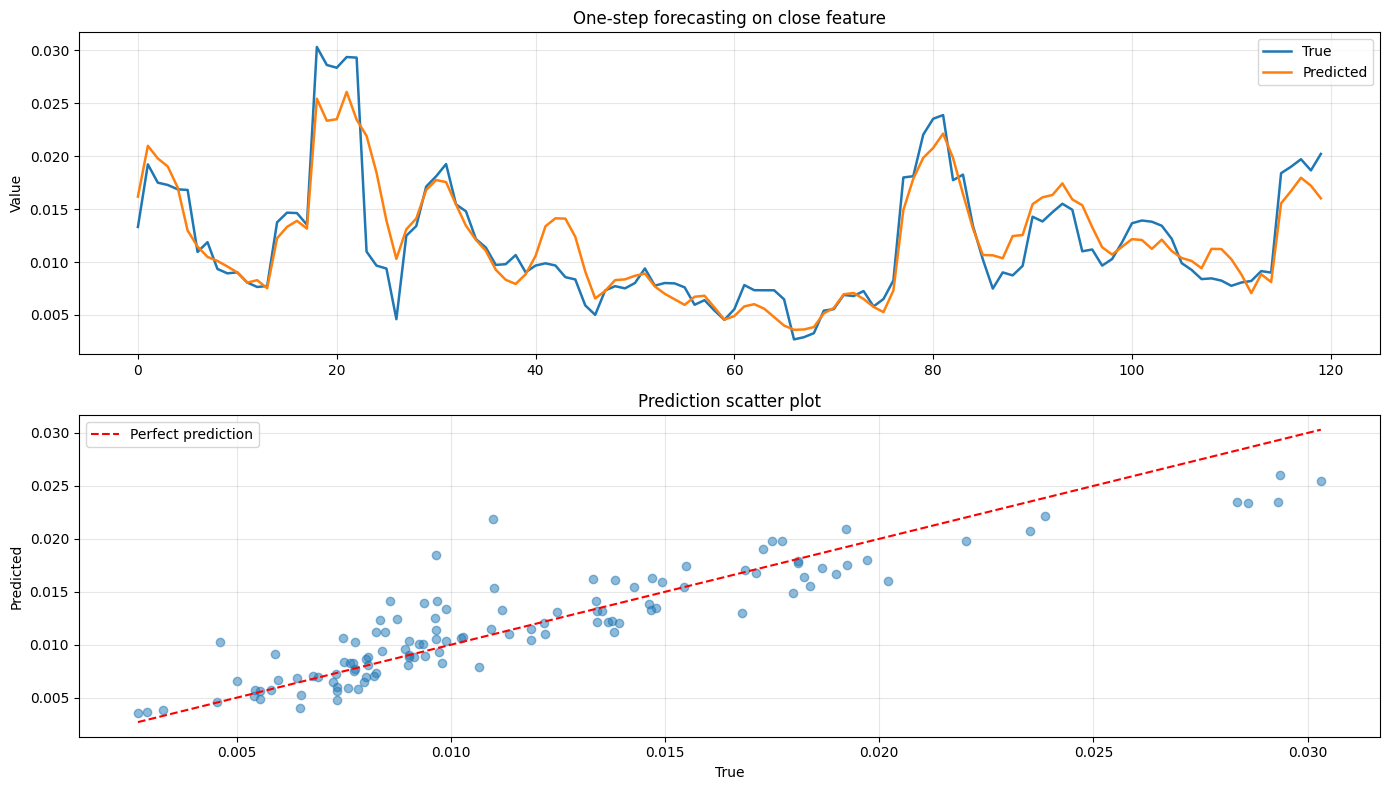

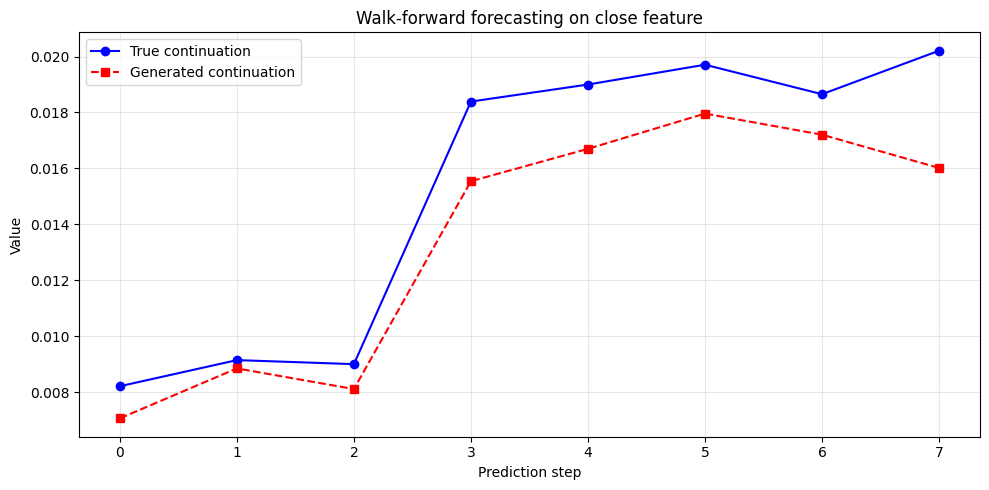

In [26]:
# Plot one-step true vs predicted values on close-price feature
samples_to_plot = min(120, y_eval.shape[0])
true_close = y_eval.to_numpy()[-samples_to_plot:, close_price_idx]
pred_close = predictions.to_numpy()[-samples_to_plot:, close_price_idx]

# Create a figure with two subplots: one for the time series comparison and one for the scatter plot
plt.figure(figsize=(14, 8))

# Plot time series comparison of true vs predicted close prices
plt.subplot(2, 1, 1)
plt.plot(true_close, label='True', linewidth=1.8)
plt.plot(pred_close, label='Predicted', linewidth=1.8)
plt.title('One-step forecasting on close feature')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)

# Plot scatter plot of true vs predicted close prices
plt.subplot(2, 1, 2)
plt.scatter(true_close, pred_close, alpha=0.5)
line_min = min(true_close.min(), pred_close.min())
line_max = max(true_close.max(), pred_close.max())
plt.plot([line_min, line_max], [line_min, line_max], 'r--', label='Perfect prediction')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Prediction scatter plot')
plt.legend()
plt.grid(alpha=0.3)

# Display the plots
plt.tight_layout()
plt.show()

# Plot autoregressive continuation on close-price feature
steps = range(available_steps)
plt.figure(figsize=(10, 5))
plt.plot(steps, true_continuation.to_numpy()[:available_steps, close_price_idx], 'b-', marker='o', label='True continuation')
plt.plot(steps, generated_sequence.to_numpy()[:available_steps, close_price_idx], 'r--', marker='s', label='Generated continuation')
plt.title(f'{generation_label} forecasting on close feature')
plt.xlabel('Prediction step')
plt.ylabel('Value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()